In [4]:
!git clone https://gitlab.com/jcnossen/fastpsf.git

fatal: destination path 'fastpsf' already exists and is not an empty directory.


In [14]:
!nvidia-smi

Tue Apr 26 14:12:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    69W / 149W |     58MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%cd /content/fastpsf
!git pull

/content/fastpsf
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://gitlab.com/jcnossen/fastpsf
   e0302f5..a9aae77  master     -> origin/master
Updating e0302f5..a9aae77
Fast-forward
 CMakeLists.txt | 15 +++++++++------
 1 file changed, 9 insertions(+), 6 deletions(-)


In [5]:
%cd /content/fastpsf
!cmake .
!make clean & make

/content/fastpsf
Targeting CUDA build...
-- Configuring done
-- Generating done
-- Build files have been written to: /content/fastpsf
[ 10%] Building CUDA object CMakeFiles/fastpsf.dir/src/CudaUtils.cu.o
[ 20%] Building CXX object CMakeFiles/fastpsf.dir/src/Context.cpp.o
[ 30%] Building CUDA object CMakeFiles/fastpsf.dir/src/GaussianPSF.cu.o
[ 40%] Building CXX object CMakeFiles/fastpsf.dir/src/Rendering.cpp.o
[ 50%] Building CXX object CMakeFiles/fastpsf.dir/src/StringUtils.cpp.o
[ 60%] Building CUDA object CMakeFiles/fastpsf.dir/src/CubicSplinePSF.cu.o
[ 70%] Building CUDA object CMakeFiles/fastpsf.dir/src/Estimator.cu.o
[ 80%] Building CUDA object CMakeFiles/fastpsf.dir/src/EstimatorImpl.cu.o
[ 90%] Linking CUDA device code CMakeFiles/fastpsf.dir/cmake_device_link.o
[100%] Linking CXX shared library bin/release/libfastpsf.so
[100%] Built target fastpsf


In [6]:
%cd /content/fastpsf/python/
!python setup.py develop

/content/fastpsf/python
running develop
running egg_info
writing fastpsf.egg-info/PKG-INFO
writing dependency_links to fastpsf.egg-info/dependency_links.txt
writing requirements to fastpsf.egg-info/requires.txt
writing top-level names to fastpsf.egg-info/top_level.txt
writing manifest file 'fastpsf.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/fastpsf.egg-link (link to .)
fastpsf 1.0 is already the active version in easy-install.pth

Installed /content/fastpsf/python
Processing dependencies for fastpsf==1.0
Searching for tqdm==4.64.0
Best match: tqdm 4.64.0
Adding tqdm 4.64.0 to easy-install.pth file
Installing tqdm script to /usr/local/bin

Using /usr/local/lib/python3.7/dist-packages
Searching for matplotlib==3.2.2
Best match: matplotlib 3.2.2
Adding matplotlib 3.2.2 to easy-install.pth file

Using /usr/local/lib/python3.7/dist-packages
Searching for numpy==1.21.6
Best match: numpy 1.21.6
Adding numpy 1.21.6 to easy-install.pth file
Installin

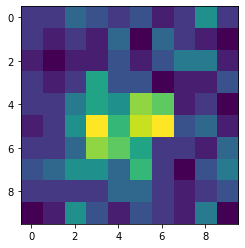

In [7]:
import matplotlib.pyplot as plt
from fastpsf import Context, GaussianPSFMethods

with Context() as ctx:
    m = GaussianPSFMethods(ctx)
    
    psf = m.CreatePSF_XYIBg(10, 1.3, cuda=True)
    
    smp = psf.GenerateSample([[4,5,100,2]])
    plt.imshow(smp[0])
    

2D Gaussian fit:
Finished. Processed 1000000 in 1.87 s. 533797.1 spots/s
Astigmatic 2D Gaussian PSF:
Finished. Processed 1000000 in 2.43 s. 410680.4 spots/s
CSpline 3D PSF:
Z min=-2.0, max=2.0. step size: 10.000
Voxels X:26, Y:26, Z:400
Finished. Processed 100000 in 0.39 s. 258662.4 spots/s


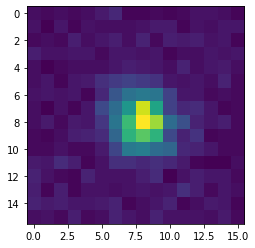

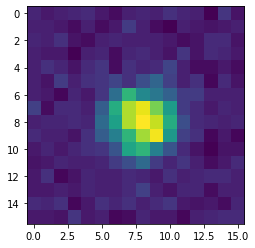

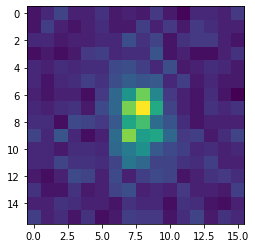

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import time

from fastpsf import (Context, CSplineCalibration, CSplinePSF,
                     GaussianPSFMethods, CSplineMethods, Gauss3D_Calibration,
                     Estimator)

import os

as_calib = Gauss3D_Calibration()

    
def test_psf_speed(ctx: Context, smp_psf:Estimator, est_psf:Estimator,
                   theta, batchSize=1024*32,repeats=1,nstreams=2, binsize=10000):
    img = smp_psf.ExpectedValue(theta)
    smp = np.random.poisson(img)
    plt.figure()
    if len(smp[0].shape)>2: 
        plt.imshow(np.concatenate(smp[0],-1))
    else:
        plt.imshow(smp[0])

    n = binsize

    repd = np.ascontiguousarray(np.repeat(smp,n,axis=0),dtype=np.float32)
    initial = np.ascontiguousarray(np.repeat(np.array(theta)*1.05,n,axis=0),dtype=np.float32)

    t0 = time.time()
    total = 0
    for i in range(repeats):
        est_psf.Estimate(repd, initial=initial)
        total += n
        
    t1 = time.time()
            
    print(f"Finished. Processed {total} in {t1-t0:.2f} s. {total/(t1-t0):.1f} spots/s")

    
with Context(debugMode=False) as ctx:
    sigma=1.5
    w = 512
    roisize=16
    theta=[[roisize//2, roisize//2, 1000, 5]]
    g_api = GaussianPSFMethods(ctx)
    psf = g_api.CreatePSF_XYIBg(roisize, sigma, True)
    #scmos = sCMOS_Calib(ctx, np.zeros((w,w)), np.ones((w,w)), np.ones((w,w))*5)
    #psf_sc = g_api.CreatePSF_XYIBg(roisize, sigma, True, scmos)
            
    #print('COM:')
    #com_est = com.CreateEstimator(roisize, ctx)
    #test_psf_speed(ctx,psf,com_est,theta, repeats=100)
    
#    test_queue_output(ctx, psf, theta)
    print('2D Gaussian fit:')
    test_psf_speed(ctx,psf,psf,theta,repeats=100)

    print('Astigmatic 2D Gaussian PSF:')
    as_psf = g_api.CreatePSF_XYZIBg(roisize, as_calib, True)
    as_theta=[[roisize//2, roisize//2, 0, 1000, 5]]
    test_psf_speed(ctx, as_psf, as_psf, as_theta,repeats=100)

    cspline_fn = 'Tubulin-A647-cspline.mat'
    #cspline_fn = "C:/data/beads/Tubulin-A647-cspline.mat"
    if not os.path.exists(cspline_fn):
        try:
            import urllib.request
            url='http://homepage.tudelft.nl/f04a3/Tubulin-A647-cspline.mat'
            print(f"Downloading {url}")
            urllib.request.urlretrieve(url, cspline_fn)
            
            if not os.path.exists(cspline_fn):
                print('Skipping CSpline 3D PSF (no coefficient file found)')
                cspline_fn = None
        finally:
            ...
    

    if cspline_fn is not None:
        print('CSpline 3D PSF:')
        calib = CSplineCalibration.from_file_nmeth(cspline_fn)
        cs_psf = CSplineMethods(ctx).CreatePSF_XYZIBg(roisize, calib, fitMode=CSplineMethods.FlatBg, cuda= True)
        cs_theta=[[roisize//2, roisize//2, 0, 1000, 5]]
        test_psf_speed(ctx,cs_psf,cs_psf, cs_theta,repeats=10)

    #print('2D Gaussian fit + sCMOS:')
    #test_psf_speed(ctx,psf_sc,psf_sc,theta)

    
        
        